In [1]:
import skimage
import skimage.io
from skimage.transform import resize

import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
from numpy.random import randint
from math import sqrt

import os
import shutil

import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2

In [2]:
# Число изображений на каждом объекте
N = 1000
# Размер изображения
img_size = 128
# Размер скрытого слоя 
p = 1777

# Название предмета изображения
imgs_name_1 = "airplane"
imgs_name_2 = "cars"

# Используемые методы в CBIR системе
numpy2vec_method = "diag"
distance_method = "norm_hamming"

In [3]:
# Импортируем и реобразует картинку в матрицу
def jpg2numpy(file_path):
    img = skimage.io.imread(file_path)
    resized_img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    return np.array(resized_img)

# Соберем все изображения в одну матрицу D
start_time = time.time()

D = np.empty((2, 1000), dtype=object)

# Количесвто изображений на каждый объект (самолет, автомобиль)
N = 1000

for j in range(N):
    # Для первого объекта
    file_path = "data_\\%s\\%d.jpg"%(imgs_name_1, j)
    D[0, j] = jpg2numpy(file_path)

    # Для второго объекта
    file_path = "data_\\%s\\%d.jpg"%(imgs_name_2, j)
    D[1, j] = jpg2numpy(file_path)

print("--- %s seconds ---" % (time.time() - start_time))

--- 41.95341491699219 seconds ---


In [4]:
# Функция, преобразоваюзая RGB изображение в серый цвет
def RGB2GRAY(img):
    return 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]

# Преобразуем в серый цвет
start_time = time.time()

imgs_gray = np.empty((2, 1000), dtype=object)

# Количесвто изображений на каждый объект (самолет, автомобиль)
N = 1000

for j in range(N):
    # Для первого объекта
    imgs_gray[0, j] = RGB2GRAY(D[0, j])
    # Для второго объекта
    imgs_gray[1, j] = RGB2GRAY(D[1, j])

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2000410556793213 seconds ---


In [5]:
# Развертывает матрицу в вектор лесенка
def diag_trans(matrix):
    matrix = np.array(matrix)
    array = []
    r = matrix.shape[0]
    for i in range(-r+1,r):
        array = np.concatenate((array,np.diag(matrix,i)),axis=None)
    return array

# Преобразует матрицу в вектор
def numpy2vec(img_g, method="row"):
    img_g = np.array(img_g)
    # Развертывание матрицы в вектор постолбцово
    if (method == "row"):
        return img_g.reshape(-1)
    # Развертывание матрицы в вектор построчно
    elif (method == "col"):
        return img_g.T.reshape(-1)
    # Развертывание матрицы в вектор лесенка
    elif (method == "diag"):
        return diag_trans(img_g)
    return 0

display(np.array([[1,2,3],[4,5,6],[7,8,9]]))
print("row:", numpy2vec([[1,2,3],[4,5,6],[7,8,9]], method="row"), "\n")
print("col:", numpy2vec([[1,2,3],[4,5,6],[7,8,9]], method="col"), "\n")
print("diag:", numpy2vec([[1,2,3],[4,5,6],[7,8,9]], method="diag"), "\n")

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

row: [1 2 3 4 5 6 7 8 9] 

col: [1 4 7 2 5 8 3 6 9] 

diag: [7. 4. 8. 1. 5. 9. 2. 6. 3.] 



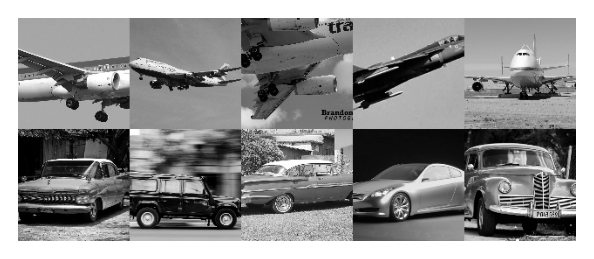

In [6]:
# Количество объектов
k = 2
# Количество примеров
exn = 5
# Создаем массивы для каждого объекта
objects = [[] for _ in range(k)]
# Создаем случайный массив для картинок - примеров изображения объектов
nums = randint(0, imgs_gray.shape[1], exn)

# Добавляем изображения в соответствующие массивы
for i in range(k):
    for j in nums:
        objects[i].append(imgs_gray[i, j])

# Склеиваем массивы по диагонали
img = []
for i in range(k):
    img.append(np.hstack(objects[i]))
img = np.vstack(img)

fig, ax = plt.subplots(figsize=(4, 8), dpi=180)

# Отображаем итоговое изображение
plt.imshow(img, cmap='gray')
# plt.axis('equal')
plt.axis('off')
plt.show()

In [7]:
# Высота изображения
wdth = img_size
# Ширина изображения
hdth = img_size
# Изначальный размер вектор-признака, далее будем оптимизимировать этот параметр
n = wdth * hdth
# Число изображений
N = 2000

# Создаем выборку X лесенкой из матрицы imgs_gray
X = np.zeros((n, N))
k = 0
for i in range(2):
    for j in range(1000):
        X[:, k] = numpy2vec(imgs_gray[i, j], method='diag').T
        k += 1

ones_vector = np.ones((X.shape[1], 1))
Xt = X - X.dot(ones_vector).dot(ones_vector.T) / N  # матрица Xt размера 16384 на 2000


In [8]:
# Xt разбиваем сингулярным разложением на U, S, V
U, S, V = np.linalg.svd(Xt, full_matrices=False)

# Усечем матрицу U
UU = U[:, :p]

# Создаем матрицу T, близкую к нулю
T = np.eye(p,p) * 0.01

In [9]:
# https://ru.wikipedia.org/wiki/Функция_активации

# Создаем функцию сигмоиду для активации
def activation(u):
    coeff_a = 0
    dx = 0.0000001
    coeff_k1 = 10 / dx #0.5
    retval = 1 / (1 + np.exp(-2.0 * coeff_k1 * (u + coeff_a)))
    return retval

coeff_a = 0;
dx = 0.0000001
coeff_k1 = 10/dx

alpha0 = 1 / (np.exp(-2 * coeff_a * coeff_k1) + 1);
alpha1 = 2 * coeff_k1 * np.exp(2 * coeff_a * coeff_k1) / ( np.exp(2 * coeff_a * coeff_k1) + 1 )**2;

# Ищем гипермараметры w1, w2 и матрицы весов W1, W2
W1 = (1 / alpha1) * T @ UU.T
W2 = UU @ np.linalg.inv(T)

w1 = -(1 / alpha1) * T @ UU.T @ (X @ np.ones((N, 1)) / N)
w2 = (np.eye(n) - UU @ UU.T) @ (X @ np.ones((N, 1)) / N) - alpha0 * UU @ np.linalg.inv(T) @ np.ones((p, 1)) - alpha1 * UU @ np.linalg.inv(T) @ w1

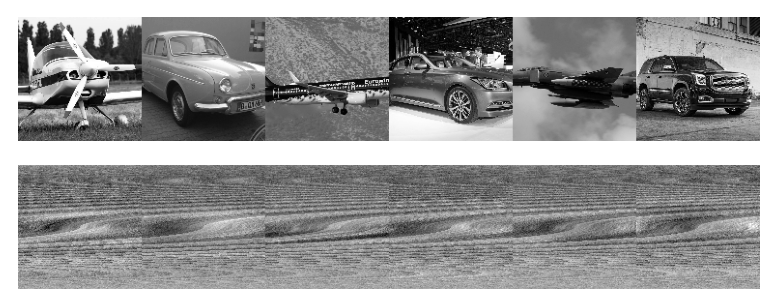

In [10]:
# Нарисуем, что выдает наша автокодировщик
def show_res_auto(obj_num, img_num):
    B = np.dot(W1, imgs_gray[obj_num, img_num].reshape(n, 1)) + w1
    H = activation(B)
    Y = np.dot(W2, H) + w2
    X_ = imgs_gray[obj_num, img_num].reshape(wdth, hdth)
    Y_ = Y.reshape(wdth, hdth)
    
    return X_, Y_

XX = np.empty((hdth, 0))
YY = np.empty((hdth, 0))
fig, ((ax1), (ax2)) = plt.subplots(2, 1,figsize=(10, 2), dpi=180)

for img_num in [300, 600, 900]:
    X_, Y_ = show_res_auto(0, img_num)
    XX = np.hstack((XX, X_))
    YY = np.hstack((YY, Y_))
    
    X_, Y_ = show_res_auto(1, img_num)
    XX = np.hstack((XX, X_))
    YY = np.hstack((YY, Y_))

max_val = np.max(YY)
min_val = np.min(YY)

diff = max_val - min_val

YY_scaled = (YY - min_val) / diff

ax1.imshow(XX, cmap='gray', aspect='equal')
ax1.axis('off')
ax2.imshow(YY_scaled, cmap='gray', aspect='equal')
ax2.axis('off')

plt.savefig('airplane_cars_auto.png', bbox_inches='tight')

In [11]:
# Получает обычный вектор признака
def get_vector_by_image(W1, w1, img):
    
    lgth = img.shape[0] * img.shape[1]
    B = np.dot(W1, img.reshape(lgth, 1)) + w1
    
    return activation(B)

# Получает бинарный вектор признака
def get_binary_vector_by_image(W1, w1, img):
    
    res = get_vector_by_image(W1, w1, img)
    # Поставляем порог равной 0.5 для бинаризации вектора
    bin_res = np.where(res > 0.5, 1, 0)
    
    return bin_res

In [12]:
# Создаем tuple_imgs вектор кортежей (номер изображения, название объекта, бинарный вектор-признак изображения)
k = 0
tuple_imgs = []

# Добавляем первый объект в кортеж tuple_imgs
for j in range(1000):
    tuple_imgs.append(tuple([j, "airplane", get_binary_vector_by_image(W1, w1, imgs_gray[0, j]).T]))
    k += 1

# Добавляем второй объект в кортеж tuple_imgs
for j in range(1000):
    tuple_imgs.append(tuple([1000 + j, "cars", get_binary_vector_by_image(W1, w1, imgs_gray[1, j]).T]))
    k += 1

In [13]:
# Перемешивает случайным образом изображений
def shuffle_imgs(matrix):
    return np.random.shuffle(matrix)

A = np.array([1, 2, 3])
print("Shuffle before:", A)
shuffle_imgs(A)
print("\t after:", A)

# Разделяет выборку на поисковую и тестовую часть
def test_search_split(matrix, test_size=0.3, shuffle=True):
    matrix_ = matrix.copy()
    if shuffle:
        shuffle_imgs(matrix_)
    size_of_matrix = len(matrix_)
    threshold = round(size_of_matrix * test_size)
    return matrix_[:threshold], matrix_[threshold:]

A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
B, C = test_search_split(A, shuffle=False)
np.testing.assert_array_equal(B, np.array([[1, 2, 3]]))
np.testing.assert_array_equal(C, np.array([[4, 5, 6], [7, 8, 9]]))
assert len(B) + len(C) == len(A)
# Делим кортежи на тестовую и поисковую часть, чтобы построить рассояние между посковой и тестовой выборки.
test_imgs_bin, search_imgs_bin = test_search_split(tuple_imgs)

Shuffle before: [1 2 3]
	 after: [3 2 1]


In [14]:
# Вариант 1
# Находит расстояние Хэмминга
def my_hamming_distance(bin1, bin2):
    dist = 0
    for n in range(len(bin1)):
        if bin1[n] != bin2[n]:
            dist += 1
    
    return dist

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert my_hamming_distance(a, b) == 2

# Находит косинусное расстояние
def my_cos_distance(bin1, bin2):
    count_one, sum_bin1, sum_bin2 = 0, 0, 0
    for i in range(len(bin1)):
        count_one += bin1[i] * bin2[i]
        sum_bin1 += bin1[i] #bin1[i]**2
        sum_bin2 += bin2[i] #bin2[i]**2
    return 1 - count_one / (sqrt(sum_bin1) * sqrt(sum_bin2))

a, b = [1, 1, 0, 0], [1, 0, 0, 0] 
assert my_cos_distance(a, b) == 0.29289321881345254

# Находит Евклидовое расстояние
def my_euclid_distance(bin1, bin2):
    dist = 0
    for i in range(len(bin1)):
        dist += (bin1[i] - bin2[i]) ** 2
    return sqrt(dist)

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert my_euclid_distance(a, b) == 1.4142135623730951

# Вариант 2
# Находит расстояние Хэмминга
def hamming_distance(bin1, bin2):
    x = np.array(bin1)
    y = np.array(bin2)  
    return np.sum(x != y)

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert hamming_distance(a, b) == 2
assert hamming_distance(a, b) == my_hamming_distance(a, b)

# Находит косинусное расстояние
def cos_distance(bin1, bin2):
    return 1 - dot(bin1, bin2) / (norm(bin1) * norm(bin2))

a, b = [1, 1, 0, 0], [1, 0, 0, 0] 
assert cos_distance(a, b) == 0.29289321881345254
assert cos_distance(a, b) == my_cos_distance(a, b)

# Находит Евклидовое расстояние
def euclid_distance(bin1, bin2):
    bin1 = np.array(bin1)
    bin2 = np.array(bin2)
    return norm(bin1 - bin2)

a = [1, 0, 1, 1, 1, 0, 1]
b = [1, 0, 0, 1, 0, 0, 1]
assert euclid_distance(a, b) == 1.4142135623730951
assert euclid_distance(a, b) == my_euclid_distance(a, b)

# Нормализует расстояние Хэмминга
def norm_hamming_distance(bin1, bin2):
    return hamming_distance(bin1, bin2) / len(bin1)

# Нормализует расстояние Хэмминга
def my_norm_hamming_distance(bin1, bin2):
    return my_hamming_distance(bin1, bin2) / len(bin1)

# Нормализует расстояние Евклидова
def norm_euclid_distance(bin1, bin2):
    return euclid_distance(bin1, bin2) / len(bin1)

# Находит расстояние
def distance(bin1, bin2, method="hamming"):
    if method == "my_hamming":
        return my_hamming_distance(bin1, bin2)
    elif method == "my_cos":
        return my_cos_distance(bin1, bin2)
    elif method == "my_euclid":
        return my_euclid_distance(bin1, bin2)
    elif method == "hamming":
        return hamming_distance(bin1, bin2)
    elif method == "cos":
        return cos_distance(bin1, bin2)
    elif method == "euclid":
        return euclid_distance(bin1, bin2)
    elif method == "norm_hamming":
        return norm_hamming_distance(bin1, bin2)
    elif method == "norm_euclid":
        return norm_euclid_distance(bin1, bin2)
    elif method == "my_norm_hamming":
        return my_norm_hamming_distance(bin1, bin2)

# Рисует диаграмму по таблице
def show_heatmap(table):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(table, ax=ax)


In [15]:
# Создаем tuple_imgs вектор кортежей
# (номер, класс изображения из поисковой выборки,
# номер, класс изображения из тестовой выборки,
# расстояние между поисковой и тестовой)

start_time = time.time()
# Количесвто изображений в тестовой выборке
test_N = 600
# Количесвто изображений в поисковой выборке
search_N = 1400
hamming_distance_matrix = []

for i in range(test_N):
    hamming_distance_list = []
    for j in range(search_N):
        hamming_distance_list.append((test_imgs_bin[i][0], test_imgs_bin[i][1],
                                      search_imgs_bin[j][0], search_imgs_bin[j][1],
                                      distance(test_imgs_bin[i][2], search_imgs_bin[j][2], method=distance_method)))

    hamming_distance_matrix.append(hamming_distance_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 9.841546773910522 seconds ---


In [16]:
# Отсортирует изображения по расстоянию
start_time = time.time()
def sort_distance(distance_matrix):
    res = []
    n = len(distance_matrix)
    for i in range(n):
        a = sorted(distance_matrix[i], key=lambda x: x[4])
        res.append(a)
    
    return res

# Создаем новый кортеж, отсортированный по расстоянию
sorted_distance = sort_distance(hamming_distance_matrix)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.28406310081481934 seconds ---


In [17]:
# Для красивого результата классификации изображений
# Проверяет на совпадение объекта
def class_by_matrix(info):
    if info[1] != info[3]:
        return 0
    else:
        return 1

# Окрашивает надпись красным цветом поисковое изображение, если объект не совпадает с тестовым
def bad_color(val):
    res = 'black'
    if (not val):
        res = 'red'
    return res

# Очишает надписи
def pretty_axis(plt, ax):
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()
    plt.tick_params(left=False, bottom=False, top=False, labelbottom=False)

In [18]:
# Рисует изображение из поисковой выборки, стоящим на j-ом месте по расстоянию от i-го тестового изображения
def show_i_nearest_img(i, j, r, k):
    nearest_img_info = sorted_distance[i][j]
    search_index, search_name = nearest_img_info[2], nearest_img_info[3]
    ax = fig.add_subplot(4, r, k + r + j * r)
    # Находим класс объекта
    class_index = search_index // 1000
    # Находим номер изображения
    index = search_index % 1000
    plt.imshow(imgs_gray[class_index, index], cmap='gray')
    pretty_axis(plt, ax)
    
    # Проверка на совпадение класса
    if (not class_by_matrix(nearest_img_info)):
        plt.title(search_name, color=bad_color(class_by_matrix(nearest_img_info)))
        return 1
    else:
        plt.title(search_name, color=bad_color(class_by_matrix(nearest_img_info)))

    return 0

4


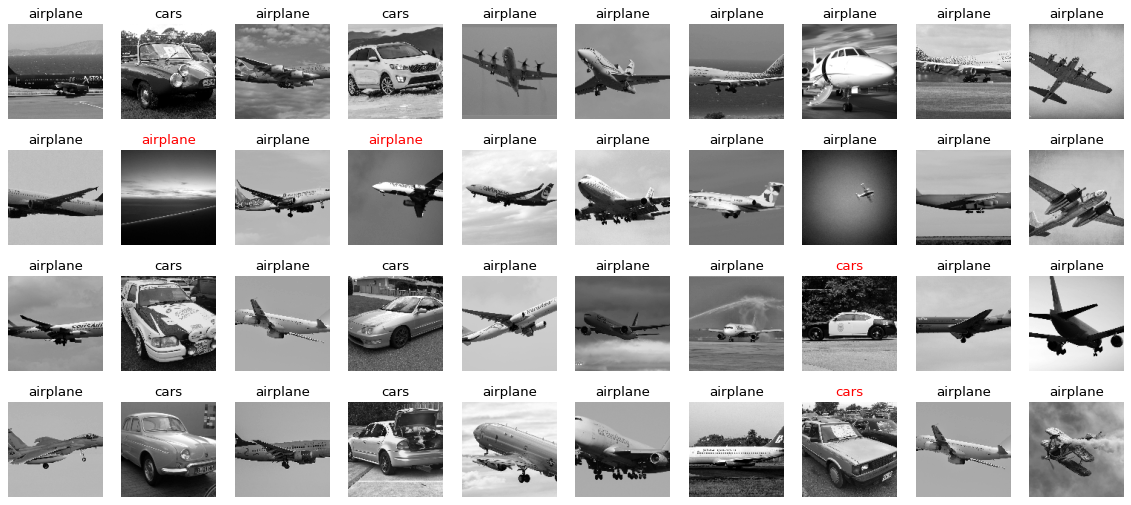

In [19]:
# Нарисуем тестовое изображение и три ближайших изображения из поисковой выборки

fig = plt.figure(figsize=(18, 8), dpi=80)

k = 1
r = 10
count_false = 0
for i in range(r):
    ax = fig.add_subplot(4, r, k)
    nearest_img_info = sorted_distance[i][0] # так как new_order[0] - это индекс самого изображения к которому ищем ближайшее
    test_index, test_name = nearest_img_info[0], nearest_img_info[1]
    # Рисуем изображение тестовой выборки
    
    class_index = test_index // 1000
    index = test_index % 1000
    plt.imshow(imgs_gray[class_index, index], cmap='gray')
    pretty_axis(plt, ax)
    plt.title(test_name)
    
    count_false += show_i_nearest_img(i, 0, r, k)
    count_false += show_i_nearest_img(i, 1, r, k)
    count_false += show_i_nearest_img(i, 2, r, k)

    k = k + 1
    plt.savefig('imgs_auto.png', bbox_inches='tight')
    
print(count_false)

In [20]:
# Найдем accuracy для всех ближайших изображений
count_false = 0
for i in range(test_N):
    nearest_img_info = sorted_distance[i][0] # так как new_order[0] - это индекс самого изображения к которому ищем ближайшее
    test_index, search_index = nearest_img_info[0], nearest_img_info[2]
    test_name, search_name = nearest_img_info[1], nearest_img_info[3]
    
    # Проверим на совпадение классов тестового изображения на поисковую
    if (not class_by_matrix(nearest_img_info)):
        count_false += 1

print("accuracy:", 1 - count_false / test_N)

accuracy: 0.7050000000000001


In [21]:
start_time = time.time()

# test_N = 600, search_N = 1400
test_search_matched = []
for i in range(test_N):
    one_line = []
    for j in range(search_N):
        one_line.append(class_by_matrix(sorted_distance[i][j]))
    test_search_matched.append(one_line)

x = [i for i in range(1, search_N)]
y = []

dist_mean = pd.DataFrame(test_search_matched).mean()

for i in range(1, search_N):
    y.append(dist_mean[:i].mean())
y = 1 - np.array(y)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6591517925262451 seconds ---


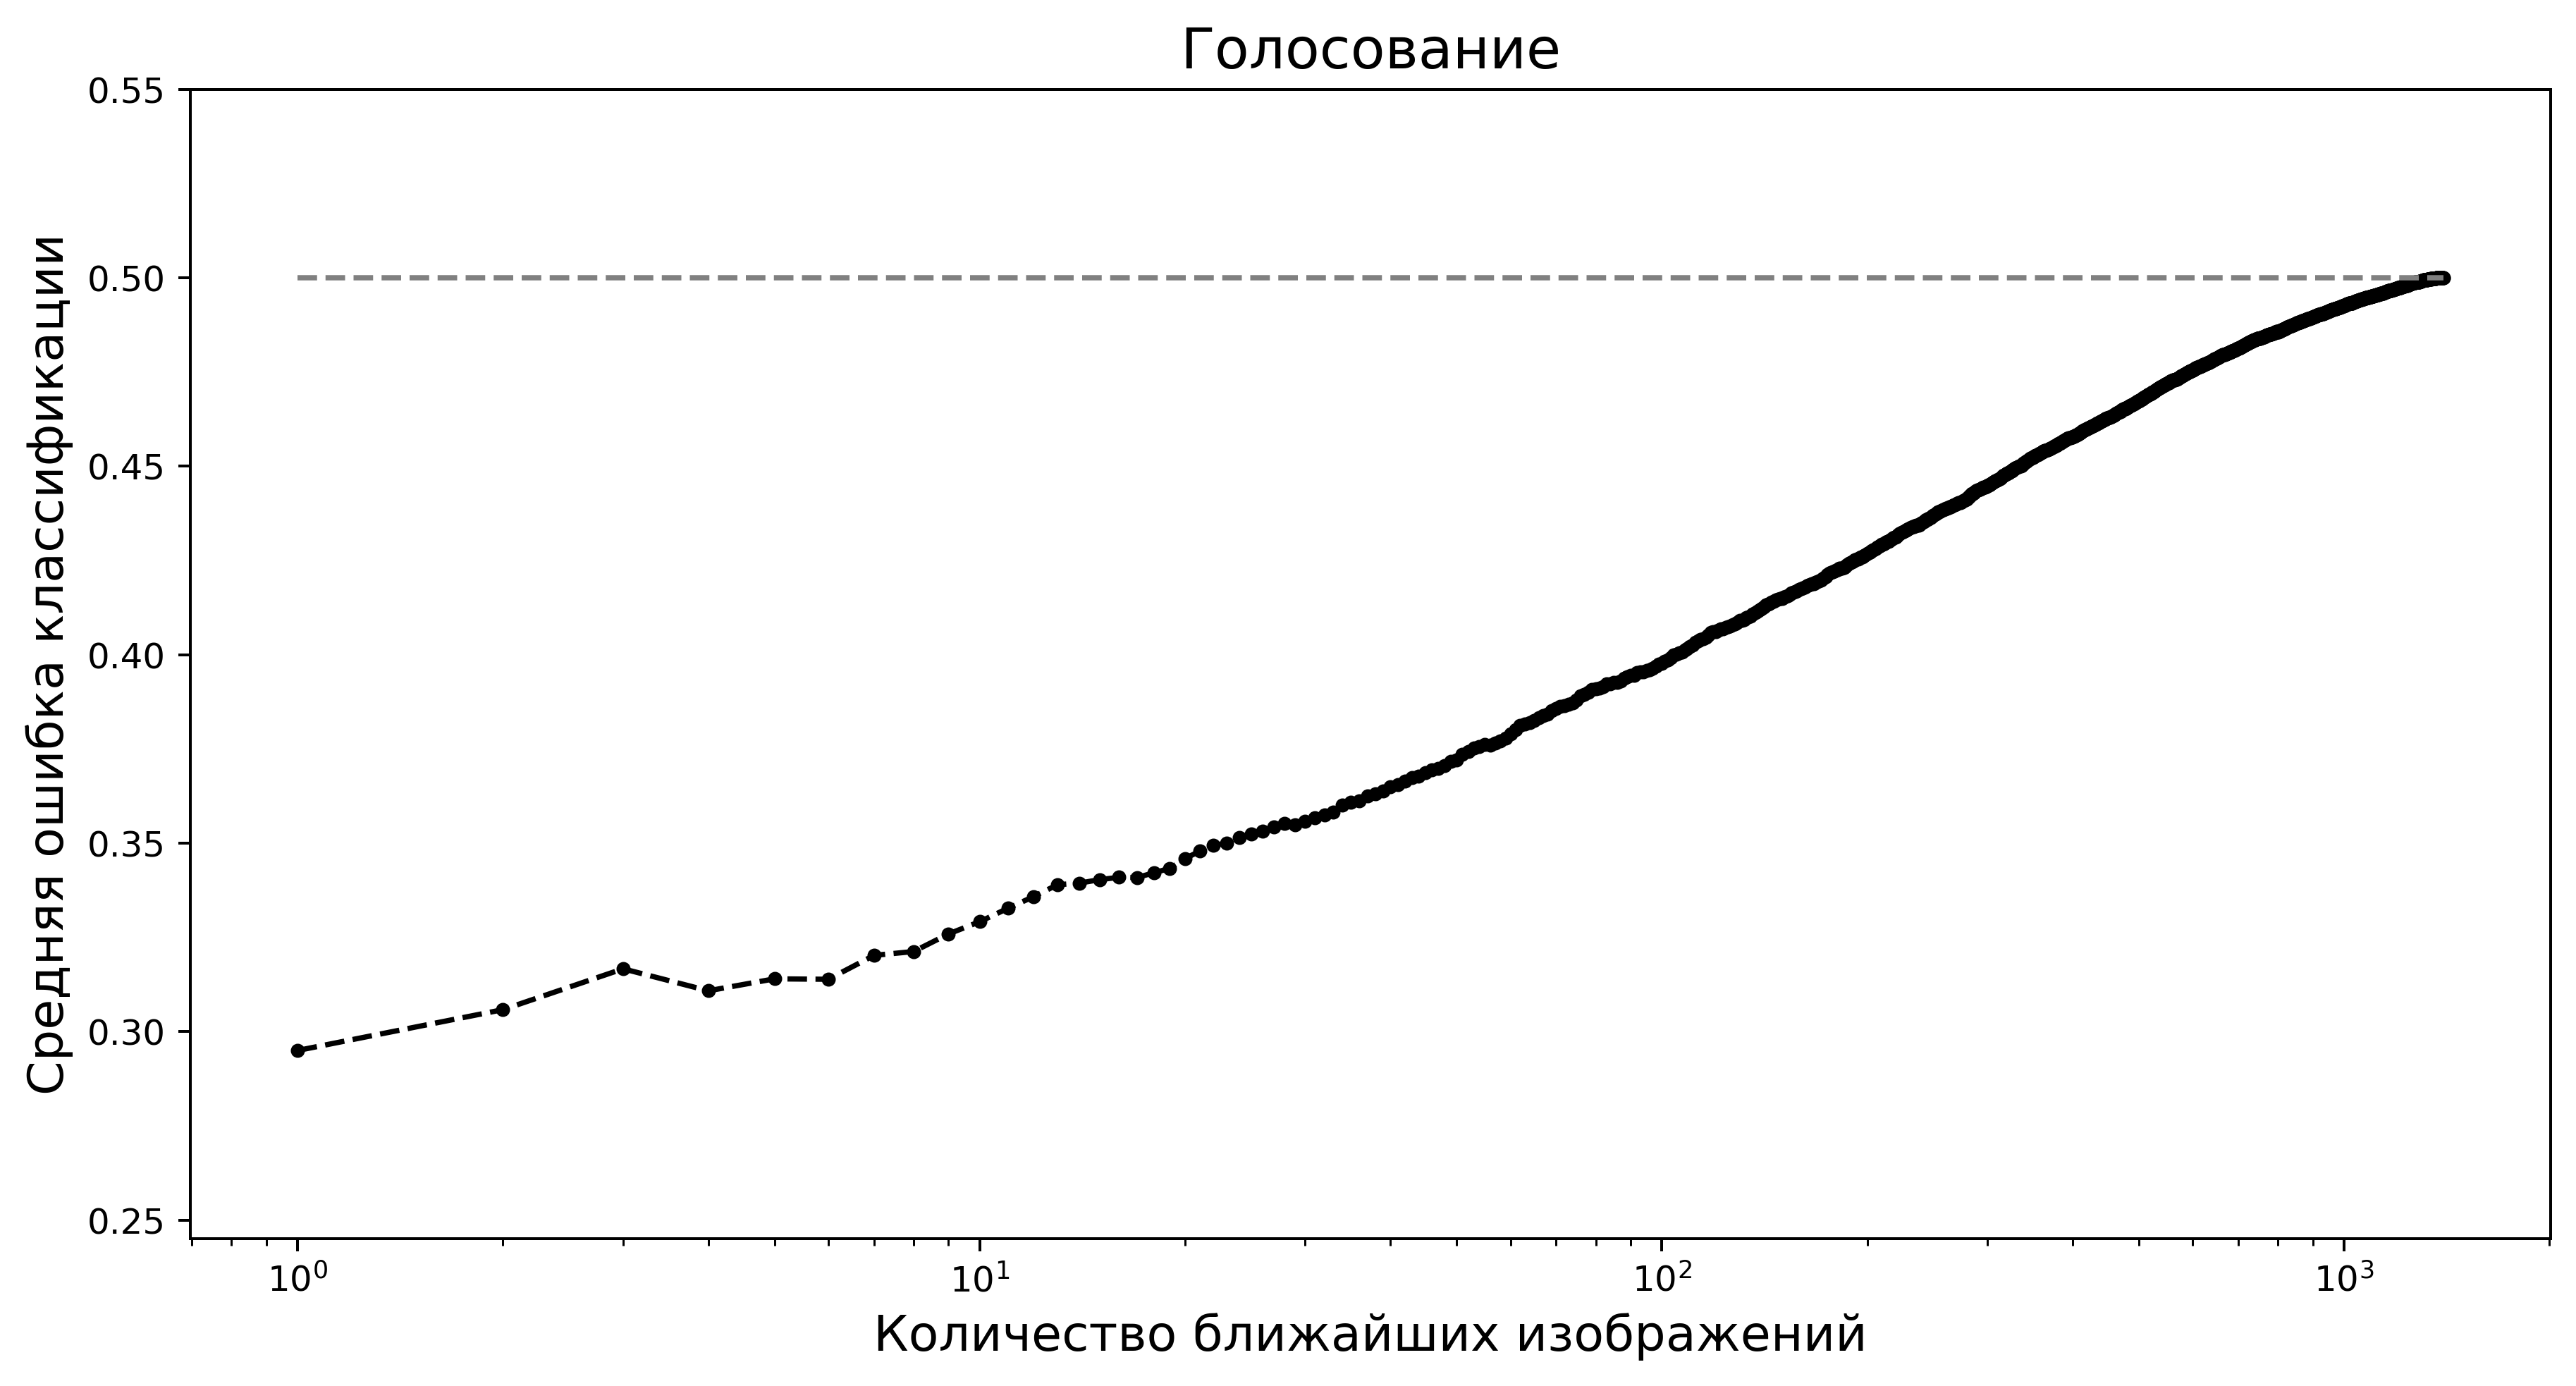

<Figure size 432x288 with 0 Axes>

In [22]:
# Нарисуем логарифмический график средней ошибки классификации от числа ближайших изображений
fig, ax = plt.subplots(figsize=(12, 6), dpi=360)
ax.set_xscale('log')
plt.plot(x, y, linestyle="--", marker=".", color="black")
plt.hlines(0.5, np.min(x), np.max(x), linestyle="--", color='gray')
plt.ylim([y.min() - 0.05, y.max() + 0.05])
plt.xlabel('Количество ближайших изображений', fontsize=14)
plt.ylabel('Средняя ошибка классификации', fontsize=14)
plt.title('Голосование', fontsize=16)
plt.show()
# Сохраняем полученный график
plt.savefig('Voting_1_auto.png', bbox_inches='tight')

In [23]:
optimal_N = np.argmin(y) + 1
print("подходящий размер ближайших изображений:", optimal_N,
      "\nоценка ошибки (accuracy):", y[optimal_N])

подходящий размер ближайших изображений: 1 
оценка ошибки (accuracy): 0.3058333333333334


In [24]:
# Функция для пострения графика ошибки классификации от размерности скрытого слоя
# на выходе получаем среднюю ошибку классификации
# Зафиксируем k=3 для построения графика средней ошибки классификации от размерности бинарного вектора
# k - количество ближайших изображений   
def collect_data_for_graph(p, k = 3):
    print(p)
    # преобразование десятчного вектора в двоичный
    # для поискового датасета
    start_time = time.time()
    # Размерность входного и выходного слоя
    n = wdth * hdth
    # Количество данных (изображений)
    N = 2000
    # Количесвто изображений в тестовой выборке
    test_N = 600
    # Количесвто изображений в поисковой выборке
    search_N = 1400
    
    U, S, V = np.linalg.svd(Xt, full_matrices=False)

    UU = U[:, :p]
    T = np.eye(p,p) * 0.01

    W1 = (1/alpha1) * T @ UU.T
    W2 = UU @ np.linalg.inv(T)

    w1 = -(1/alpha1) * T @ UU.T @ (X @ np.ones((N, 1)) / N)
    w2 = (np.eye(n) - UU @ UU.T) @ (X @ np.ones((N, 1)) / N) - alpha0 * UU @ np.linalg.inv(T) @ np.ones((p, 1)) - alpha1 * UU @ np.linalg.inv(T) @ w1
    
    tuple_imgs = []
    for i in range(2):
        for j in range(1000):
            tuple_imgs.append(tuple([1000 * i + j, i, get_binary_vector_by_image(W1, w1, imgs_gray[i,j]).T]))

    # разбиение на тестовую и поисковую для проверки модели автокодировщика
    test_imgs_bin, search_imgs_bin = test_search_split(tuple_imgs, shuffle=False)
      
    # Создадим hamming_distance_list вектор кортежей
    # (номер, класс изображения из поисковой выборки,
    # номер, класс изображения из тестовой выборки,
    # расстояние между поисковой и тестовой)

    hamming_distance_matrix = []

    for i in range(test_N):
        hamming_distance_list = []
        for j in range(search_N):
            hamming_distance_list.append((test_imgs_bin[i][0], test_imgs_bin[i][1],
                                          search_imgs_bin[j][0], search_imgs_bin[j][1],
                                          distance(test_imgs_bin[i][2], search_imgs_bin[j][2], method=distance_method)))
        hamming_distance_matrix.append(hamming_distance_list)
        
    sorted_distance = sort_distance(hamming_distance_matrix)
    
    # test_N = 600, search_N = 1400
    test_search_matched = []
    for i in range(test_N):
        one_line = []
        for j in range(search_N):
            one_line.append(class_by_matrix(sorted_distance[i][j]))
        test_search_matched.append(one_line)

    dist_mean = pd.DataFrame(test_search_matched).mean()

    print("p =", p, " \taccuracy =", dist_mean[:k].mean())
    print("--- %s seconds ---" % (time.time() - start_time))
    return dist_mean[:k].mean()

In [25]:
# Подготовим для построения графика средней ошибки классификации от размера скрытого слоя
ps = np.linspace(1, N, num=10)
# Не имеет рассматривать скрытый слой с размером единицы, начнем с 100
ps[0] = 100
y = []
for p in ps:
    y.append(collect_data_for_graph(int(p)))

y = 1 - np.array(y)
n = len(y)
x = [i for i in ps][:len(y)]

100
p = 100  	accuracy = 0.6583333333333333
--- 36.27734017372131 seconds ---
223
p = 223  	accuracy = 0.686111111111111
--- 28.04489040374756 seconds ---
445
p = 445  	accuracy = 0.7077777777777777
--- 30.311445474624634 seconds ---
667
p = 667  	accuracy = 0.7233333333333333
--- 44.66466403007507 seconds ---
889
p = 889  	accuracy = 0.7288888888888888
--- 38.898051738739014 seconds ---
1111
p = 1111  	accuracy = 0.7277777777777779
--- 45.46058249473572 seconds ---
1333
p = 1333  	accuracy = 0.7338888888888889
--- 53.6537504196167 seconds ---
1555
p = 1555  	accuracy = 0.7327777777777778
--- 61.90558362007141 seconds ---
1777
p = 1777  	accuracy = 0.7444444444444445
--- 55.21568465232849 seconds ---
2000
p = 2000  	accuracy = 0.7388888888888889
--- 52.289307832717896 seconds ---


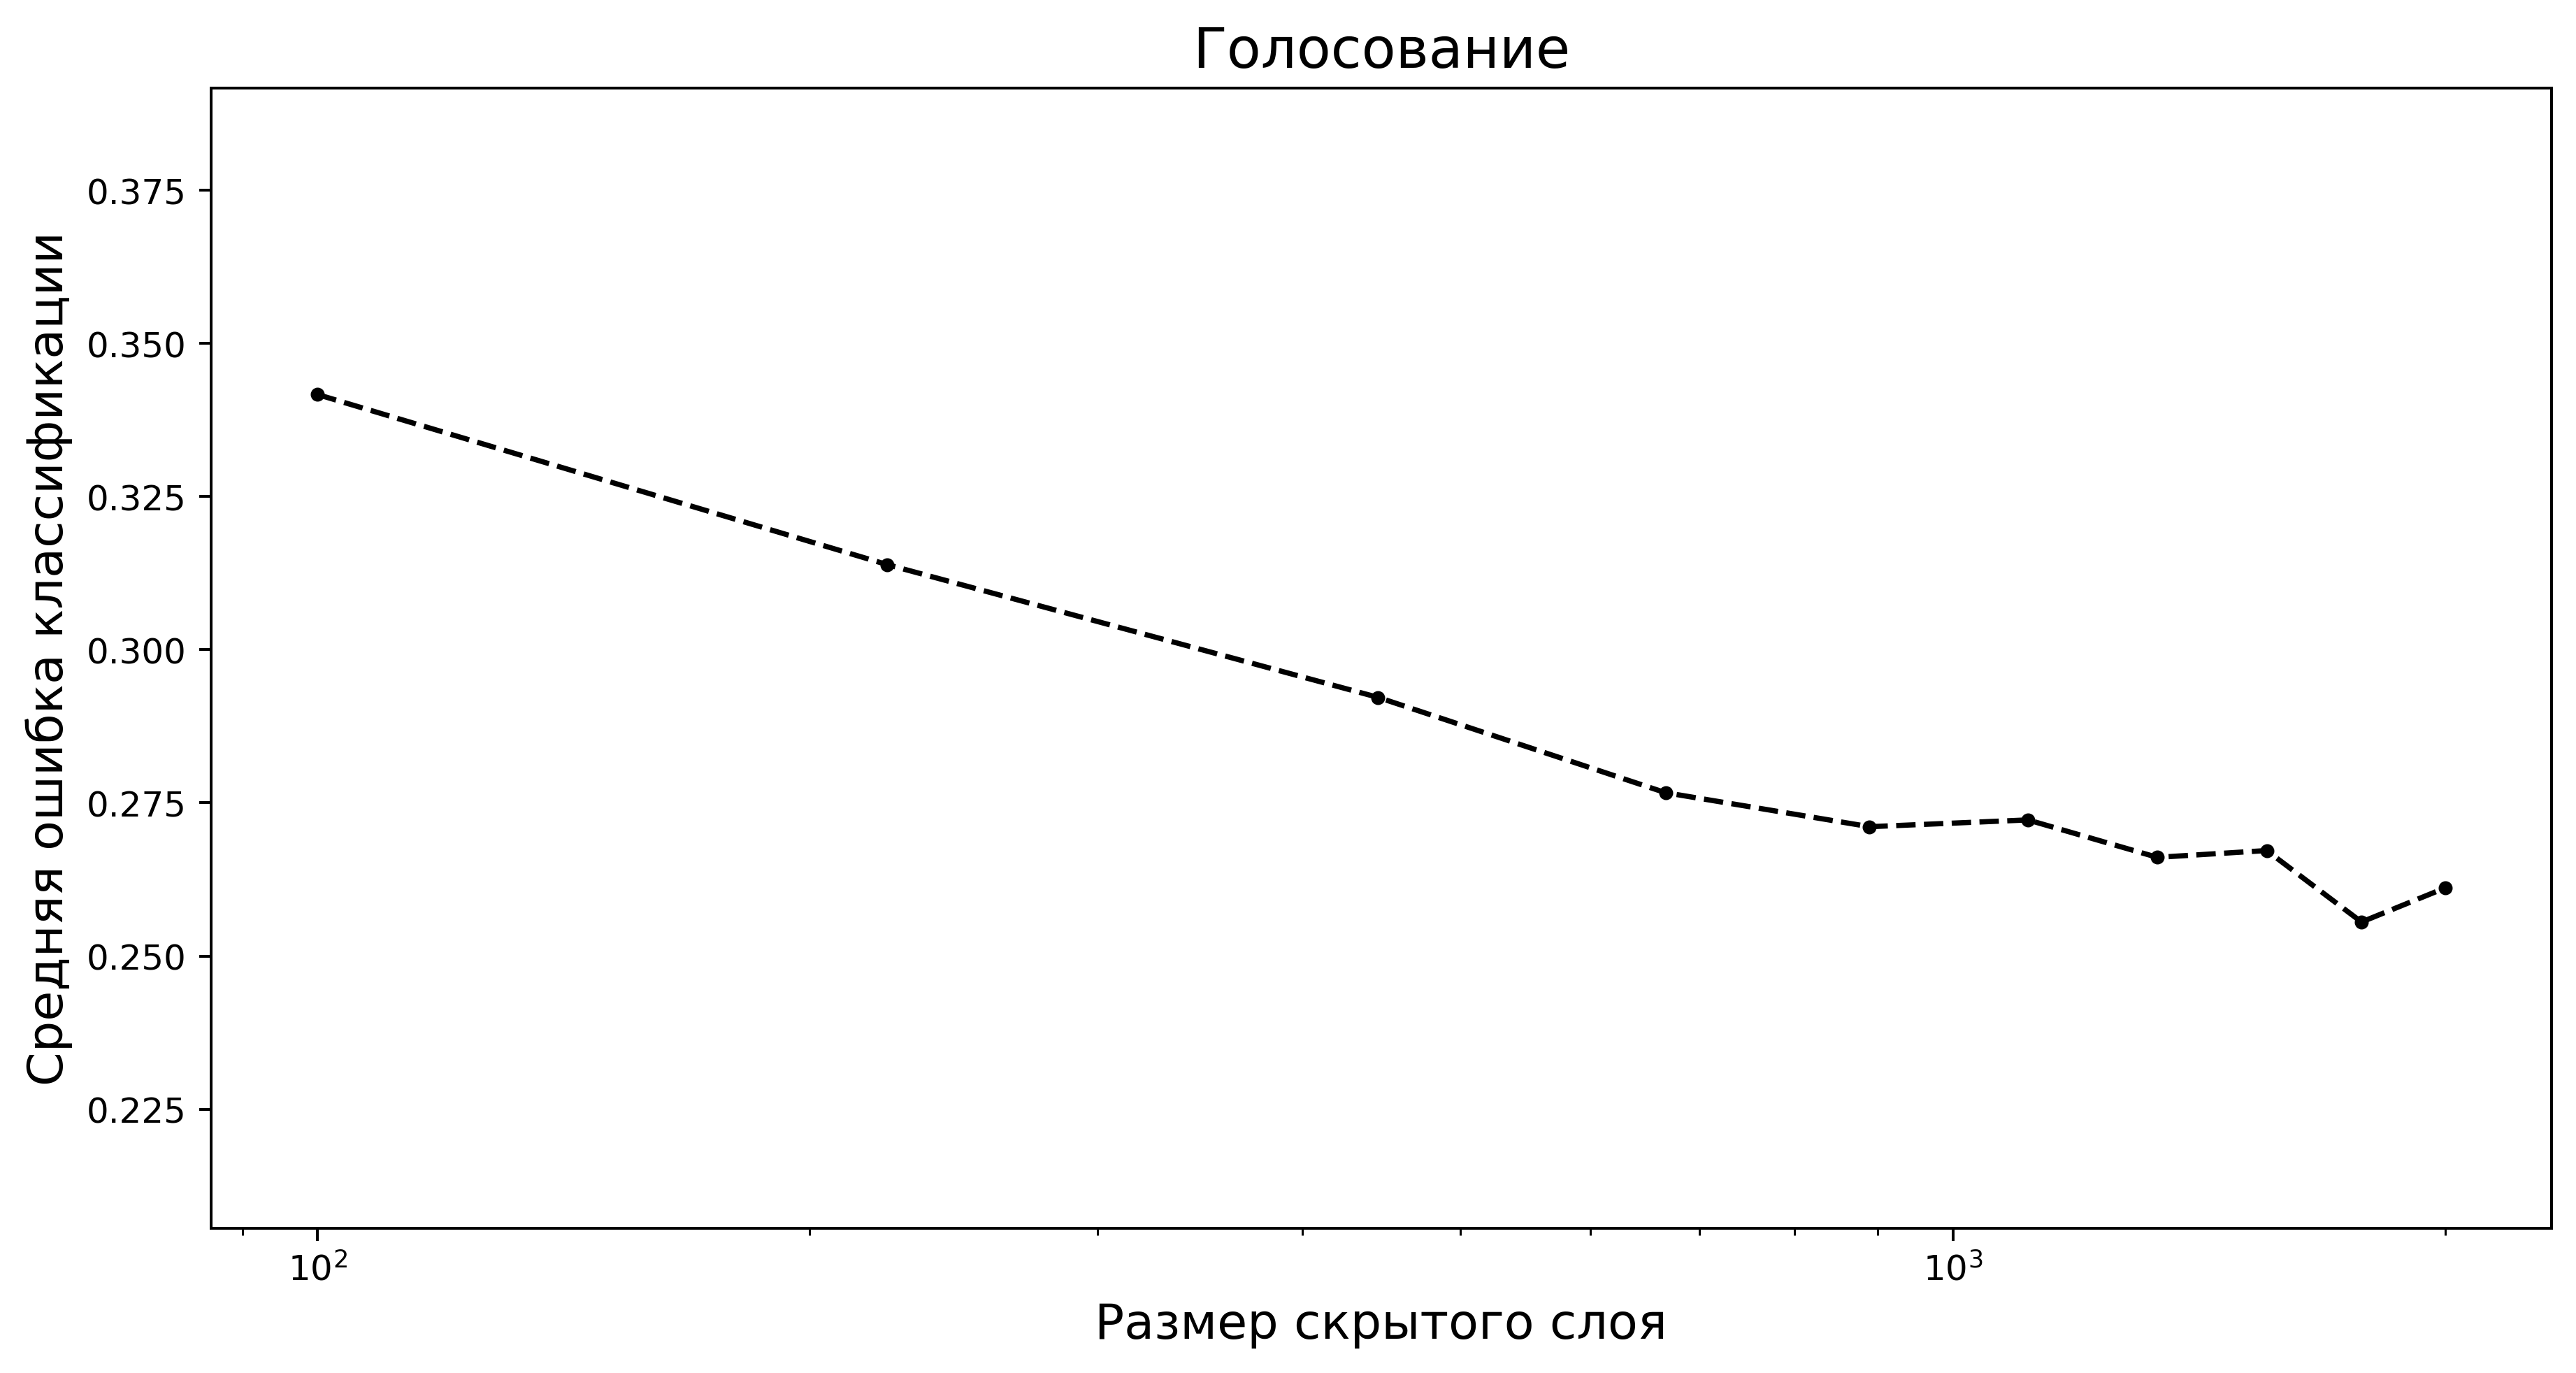

In [26]:
# Нарисуем логарифмический график средней ошибки классификации от размера скрытого слоя
fig, ax = plt.subplots(figsize=(12, 6), dpi=360)
ax.set_xscale('log')
plt.plot(x, y, linestyle="--", marker=".", color="black")
plt.hlines(0.5, np.min(x), np.max(x), linestyle="--", color='gray')
plt.ylim([y.min() - 0.05, y.max() + 0.05])
plt.xlabel('Размер скрытого слоя', fontsize=14)
plt.ylabel('Средняя ошибка классификации', fontsize=14)
plt.title('Голосование', fontsize=16)
# Сохраняем полученный график
plt.savefig('Voting_2_auto.png', bbox_inches='tight')
plt.show()

In [27]:
optimal_N = np.argmin(y)
print("подходящий размер ближайших изображений:", int(x[optimal_N]),
      "\nоценка ошибки (accuracy):", y[optimal_N])

подходящий размер ближайших изображений: 1777 
оценка ошибки (accuracy): 0.25555555555555554


In [28]:
collect_data_for_graph(int(x[optimal_N]), k = 1)

1777
p = 1777  	accuracy = 0.765
--- 49.334837436676025 seconds ---


0.765

In [29]:
# y = [0.5       , 0.31388889, 0.29222222, 0.27666667, 0.27111111,
#     0.27222222, 0.26611111, 0.26722222, 0.25555556, 0.26111111]